# LSTM Model

## 1. Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# Load Dataset
df = pd.read_csv('Dataset/5G_NIDD_Full.csv')

In [3]:
df.shape

(6282130, 22)

In [4]:
df.head()  # Display the first few rows of the DataFrame

,frame.time_relative,ip.src,ip.dst,ip.len,tcp.flags.syn,tcp.flags.ack,tcp.flags.push,tcp.flags.fin,tcp.flags.reset,tcp.flags.ece,...,eth.dst,ip.hdr_len,ip.ttl,tcp.window_size_value,tcp.hdr_len,udp.length,srcport,dstport,flow.id,label
0,0.000000,10.50.150.200,10.155.15.1,84,NaN,NaN,NaN,NaN,NaN,NaN,...,a8:6b:ad:fd:04:b4,20,58,0,0,0,0,0,10.50.150.200 10.155.15.1 0 0 1,Benign
1,0.839253,10.50.150.200,10.155.15.6,84,NaN,NaN,NaN,NaN,NaN,NaN,...,a8:6b:ad:fd:04:b4,20,58,0,0,0,0,0,10.50.150.200 10.155.15.6 0 0 1,Benign
2,0.898380,10.155.15.6,10.50.150.200,84,NaN,NaN,NaN,NaN,NaN,NaN,...,cc:48:3a:f9:0f:21,20,64,0,0,0,0,0,10.155.15.6 10.50.150.200 0 0 1,Benign
3,0.964037,10.50.150.200,10.155.15.0,84,NaN,NaN,NaN,NaN,NaN,NaN,...,a8:6b:ad:fd:04:b4,20,58,0,0,0,0,0,10.50.150.200 10.155.15.0 0 0 1,Benign
4,1.341397,10.155.15.0,109.105.109.207,216,NaN,NaN,NaN,NaN,NaN,NaN,...,cc:48:3a:f9:0f:21,20,64,0,0,196,49920,443,10.155.15.0 109.105.109.207 49920 443 17,Benign


In [5]:
# Drop Unnecessary Columns
columns_to_drop = ['ip.src', 'ip.dst', 'eth.src', 'eth.dst', 'flow.id']
df = df.drop(columns=columns_to_drop)

In [6]:
# Identify Columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [7]:
# Remove label from categorical for later encoding
target_col = 'label'
cat_features = [col for col in categorical_cols if col != target_col]

In [8]:
# Handle Missing Values
for col in cat_features:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

In [9]:
# Drop Duplicates
df.drop_duplicates(inplace=True)

In [10]:
# One-hot Encode Categorical Features (except target)
if cat_features:  # Only run if there are any remaining categorical features
    onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_cats = onehot_encoder.fit_transform(df[cat_features])
    encoded_cat_cols = onehot_encoder.get_feature_names_out(cat_features)
    encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoded_cat_cols, index=df.index)
    df = df.drop(columns=cat_features)
    df = pd.concat([df, encoded_cat_df], axis=1)

In [11]:
# Standardize Numerical Features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [12]:
# Encode Target (label) to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df[target_col] = label_encoder.fit_transform(df[target_col])
print("Label classes:", label_encoder.classes_)

df.value_counts(['label'])

Label classes: ['Benign' 'HTTPFlood' 'ICMPFlood' 'SYNFlood' 'SYNScan' 'SlowrateDoS'
 'TCPConnectScan' 'UDPFlood' 'UDPScan']


label
0        2834524
1         858100
7         733760
5         617151
3          26458
6          20373
4          20152
8          15949
2           2309
dtype: int64

            Label    Count
0          Benign  2834524
1       HTTPFlood   858100
2       ICMPFlood     2309
3        SYNFlood    26458
4         SYNScan    20152
5     SlowrateDoS   617151
6  TCPConnectScan    20373
7        UDPFlood   733760
8         UDPScan    15949


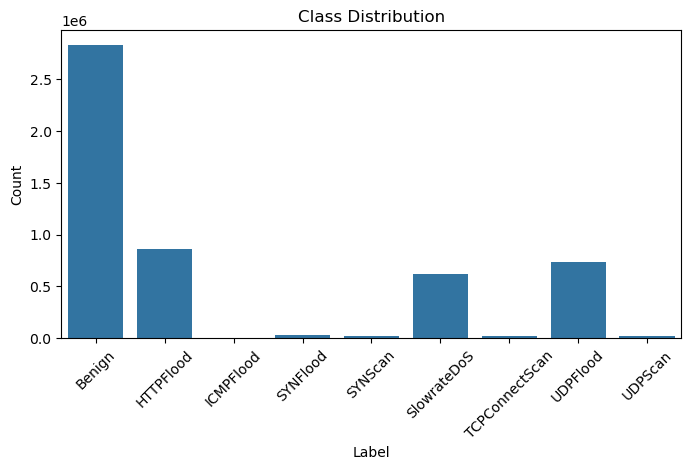

In [13]:
# Class Distribution Table
label_counts = df[target_col].value_counts().sort_index()
label_counts_table = pd.DataFrame({'Label': label_encoder.classes_, 'Count': label_counts.values})
print(label_counts_table)

plt.figure(figsize=(8,4))
sns.barplot(x=label_counts_table['Label'], y=label_counts_table['Count'])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Separate X and y
X = df.drop(columns=[target_col])
y = df[target_col]  # integer labels

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
# One-hot encode y for model training (Keras expects one-hot for softmax)
y_train_oh = pd.get_dummies(y_train)
y_test_oh = pd.get_dummies(y_test)

# Align columns
y_test_oh = y_test_oh.reindex(columns=y_train_oh.columns, fill_value=0)

In [17]:
# Reshape for 3D-LSTM (timesteps > 1 for sequence modeling)
# Use a sliding window approach to create sequences
def create_sequences(X, y, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X.iloc[i:i+seq_len].values)
        ys.append(y.iloc[i+seq_len-1])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 5 # Length of the sequence for LSTM
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_len=SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_len=SEQ_LEN)

# One-hot encode y for model training
y_train_seq_oh = pd.get_dummies(y_train_seq)
y_test_seq_oh = pd.get_dummies(y_test_seq)
y_test_seq_oh = y_test_seq_oh.reindex(columns=y_train_seq_oh.columns, fill_value=0)

In [18]:
print("Train shape:", X_train_seq.shape, y_train_seq_oh.shape)
print("Test shape:", X_test_seq.shape, y_test_seq_oh.shape)

Train shape: (4103016, 5, 16) (4103016, 9)
Test shape: (1025752, 5, 16) (1025752, 9)


# Vanila LSTM

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Define Vanilla LSTM Model
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = LSTM(64, return_sequences=False)(inputs)
x = Dropout(0.3)(x)
outputs = Dense(y_train_seq_oh.shape[1], activation='softmax')(x)
vanilla_lstm_model = Model(inputs, outputs, name="Vanilla_LSTM")

vanilla_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vanilla_lstm_model.summary()

In [ ]:
history_vanilla = vanilla_lstm_model.fit(
    X_train_seq, y_train_seq_oh,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq_oh)
)

# BiLSTM

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Define Single-Layer BiLSTM Model
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=False))(inputs)
x = Dropout(0.3)(x)
outputs = Dense(y_train_seq_oh.shape[1], activation='softmax')(x)
bilstm_model = Model(inputs, outputs, name="Single_Layer_BiLSTM")

bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bilstm_model.summary()

In [ ]:
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq_oh,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq_oh)
)

# LSTM + Attention

In [ ]:
from tensorflow.keras.layers import AdditiveAttention, Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Define Vanilla LSTM + Attention Model
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
attention = AdditiveAttention()([x, x])  # Apply attention
x = tf.keras.layers.Flatten()(attention)  # Flatten the attention output
x = Dropout(0.3)(x)
outputs = Dense(y_train_seq_oh.shape[1], activation='softmax')(x)
vanilla_lstm_attention_model = Model(inputs, outputs, name="Vanilla_LSTM_Attention")

vanilla_lstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vanilla_lstm_attention_model.summary()

In [ ]:
history_vanilla_attention = vanilla_lstm_attention_model.fit(
    X_train_seq, y_train_seq_oh,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq_oh)
)

## BiLSTM + Attention Model

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
# Define BiLSTM + Attention Model
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
attention = Attention()(x)  # Apply custom attention layer
x = Dropout(0.3)(attention)
outputs = Dense(y_train_seq_oh.shape[1], activation='softmax')(x)
bilstm_attention_model = Model(inputs, outputs, name="BiLSTM_Attention")

bilstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bilstm_attention_model.summary()

In [ ]:
history_bilstm_attention = bilstm_attention_model.fit(
    X_train_seq, y_train_seq_oh,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq_oh)
)